In [1]:
'''
This notebook is based on the source code here:
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

'''
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH = r'/Desktop/Python/Credit Card'
data = pd.read_csv('./input/creditcard.csv')

In [3]:
data.head().T

,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


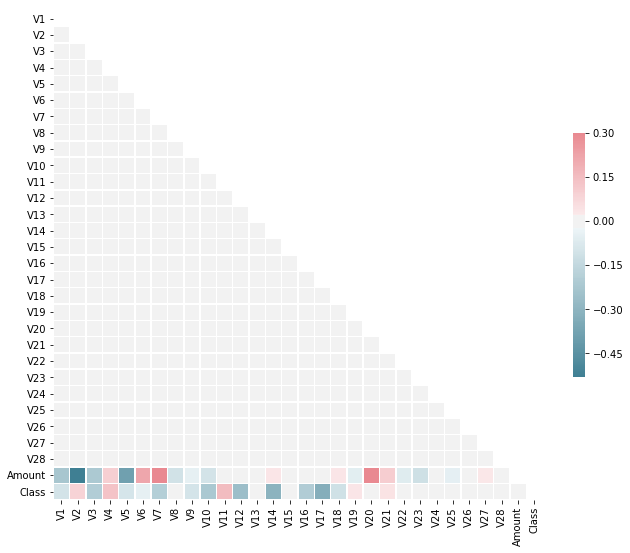

In [12]:
corr = data.loc[:, 'V1':].corr()

# The following code is taken from seaborn webpage
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Columns V1 to V28 are PCAs, so their correlation with one another is zero.

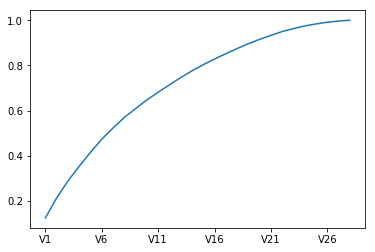

In [26]:
var = np.square(data.loc[:, 'V1':'V28'].std())
totalVar = np.sum(var)
pct = np.cumsum(var)/totalVar
pct.plot()

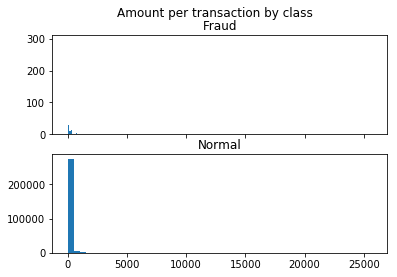

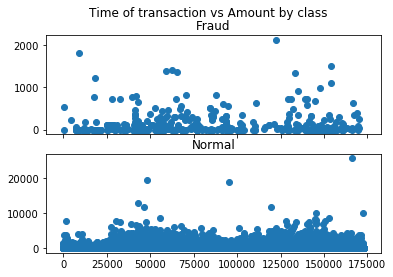

In [43]:
frauds = data.loc[data.Class == 1]
normal = data.loc[data.Class == 0]

# Plot the amount
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

######
# Plot the time
######
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

## Create training and testing data
Here I do it differently from the blog. The blog discards the positive cases of the training set. Here I concatenate that to the testing set. There is no data leakage because the model is not built on the positive training cases.

However, performance suffers.

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

RANDOM_SEED = 42
X_train, X_test = train_test_split(data.drop(['Time'], axis = 1), test_size=0.2, random_state=RANDOM_SEED)

# Unsupervised during training
# we only select the negative test cases
X_train_positive = X_train[X_train.Class == 1]

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train['Amount'] = scaler.fit_transform(X_train.Amount.values.reshape(-1,1))

X_test = pd.concat([X_train_positive, X_test])
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1, 1))

(227451, 29)
(57356, 29) 492


In [65]:
X_train = X_train.values
X_test = X_test.values
print(X_train.shape)
print(X_test.shape,  np.sum(y_test))

(227451, 29)
(57356, 29) 492


In [35]:
input_dim = X_train.shape[1]
encoding_dim = 14

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from scipy import stats 

def MyModel(input_dim):
    input_layers = Input(shape = (input_dim, ))
    
    encoder = Dense(encoding_dim, activation="elu",
                    activity_regularizer=regularizers.l1(10e-5))(input_layers)
    
    represent = Dense(int(encoding_dim/2), activation = "elu")(encoder)
    
    decoder = Dense(input_dim, activation = "elu")(represent)
    autoencoder = Model(inputs=input_layers, outputs = decoder)
    return autoencoder

def ExampleModel(input_dim):
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation="tanh", 
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
    decoder = Dense(input_dim, activation='relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

Using TensorFlow backend.


In [75]:
import time 
nb_epoch = 10
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

autoencoder = MyModel(input_dim)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

start = time.time()

### autoencoder.fit will return an object that contains history
### notice: .history at the end
### history is a dictionary
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0,
                    callbacks=[checkpointer, tensorboard]).history
                          
end = time.time()
print("runtime",(end-start)/60)

runtime 1.203236977259318


In [76]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_9 (Dense)              (None, 29)                232       
Total params: 757
Trainable params: 757
Non-trainable params: 0
_________________________________________________________________


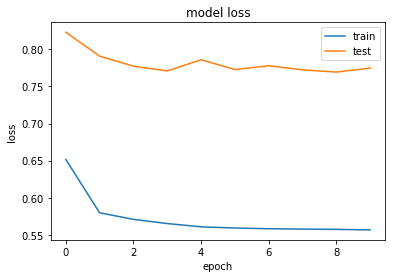

In [77]:
### Visualizing the training process
autoencoder.save("model.h5")

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

We can certainly try for more epoches, but it seems that the reconstruction for the testing cases almost flatten at 3 epoches. The error of test sets are bound to be higher, particularly due to all the fraud cases. 

Let's test the reconstruction error of our model. We can see that there is a relative difference in Reconstruction Error between the Fraud and non-fraud instances.

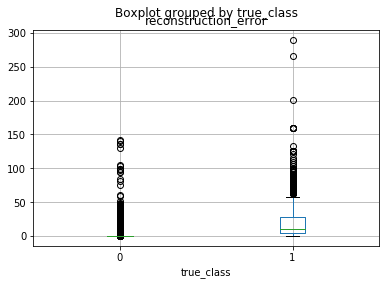

In [78]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.boxplot(column='reconstruction_error', by = 'true_class')

In [84]:
pd.options.display.float_format = '{:,.2f}'.format
error_df.groupby('true_class').describe()

reconstruction_error                                         
                          count  mean   std  min  25%   50%   75%    max
true_class                                                              
0                     56,864.00  0.53  2.36 0.03 0.16  0.26  0.45 141.35
1                        492.00 27.43 38.44 0.12 4.71 10.48 27.61 289.91

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D4FDEB8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000227E7710>], dtype=object)

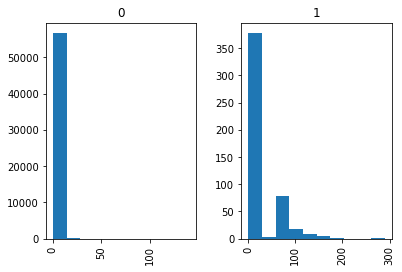

In [80]:
error_df.hist(column = 'reconstruction_error', by = 'true_class')

(0, 300)

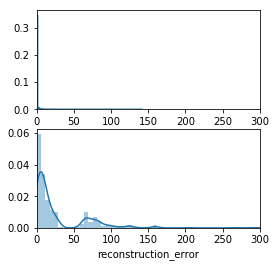

In [81]:
# Fancier visualization
normal_error_df = error_df[error_df['true_class']== 0]
fraud_error_df = error_df[error_df['true_class']== 1]

f, (ax1, ax2) = plt.subplots(2,1, figsize = (4, 4))
sns.distplot(normal_error_df.reconstruction_error, ax=ax1)
ax1.set_xlim(0, 300)

sns.distplot(fraud_error_df.reconstruction_error, ax=ax2)
ax2.set_xlim(0, 300)

The article proceeds to identify fraud cases using Reconstruction Error. 

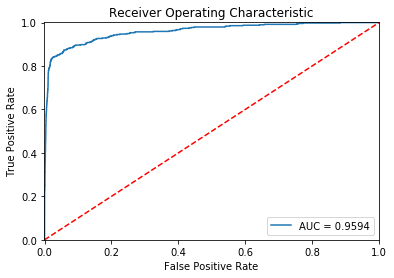

In [82]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Let's decide on a threshold. From the graph, it seems that if we have fpr around 20%, we can reach tpr that is close to 1.

In [83]:
index = len(fpr[fpr < 0.2]) - 1
chosenThreshold = thresholds[index]
print(tpr[index])
print(fpr[index])

0.939024390244
0.198807681486
